### Домашнее задание 4. Конструирование текстовых признаков из твитов пользователей

## Сбор данных

Первый этап - сбор твитов пользователей. Необходимо подключаться к Twitter API и запрашивать твиты по id пользователя. 
Подключение к API подробно описано в ДЗ 1.

In [27]:
import twitter
import os
import time
import json
import pandas as pd

In [28]:
CONSUMER_KEY = "uaEg7Js5CmZhfXVxKcJJlnYDe"
CONSUMER_SECRET = "ObLvTUZgpze7nxip5zVvVuF1YZCNoHyxWUar5UqTT0zunTamPc"

ACCESS_TOKEN_KEY = "3064685049-dWPWCkRoncnznCxHcoDwuKBB1LWpbmefwFlVM3k"
ACCESS_TOKEN_SECRET = "v9bOQ2PUAVCV5iGq2IYTE191lYLEKG41MmiS8CKdwVGkn"

api = twitter.Api(consumer_key=CONSUMER_KEY, 
                  consumer_secret=CONSUMER_SECRET, 
                  access_token_key=ACCESS_TOKEN_KEY, 
                  access_token_secret=ACCESS_TOKEN_SECRET)

Для получения твитов пользователя может быть использован метод GetUserTimeline из библиотеки python-twitter. Он позволяет получить не более 200 твитов пользователя. По каждому пользователю достаточно собрать 200 твитов.

Метод имеет ограничение по количеству запросов в секунду. Для получения информации о промежутке времени, которое необходимо подождать для повторного обращения к API может быть использован метод `GetSleepTime`. Для получения информации об ограничениях запросов с помощью метода `GetUserTimeLine` необходимо вызывать `GetSleepTime` с параметром "statuses/user_timeline".

Метод GetUserTimeline возвращает объекты типа Status. У этих объектов есть метод AsDict, который позволяет представить твит в виде словаря.

Id пользователей необходимо считать из файла, как было сделано в ДЗ 1.

Необходимо реализовать функцию `get_user_tweets(user_id)`. Входной параметр - id пользователя из файла. Возвращаемое значение - массив твитов пользователя, где каждый твит представлен в виде словаря. Предполагается, что информация о пользователе содержится в твитах, которые пользователь написал сам. Это означает, что можно попробовать отфильтровать ответы другим пользователям, ссылки и ретвиты, а так же картинки и видео, так как наша цель - найти текстовую информацию.

In [29]:
def get_user_tweets(user_id):
    """returns list of tweets as dicts"""
    # your code here
    try:
        sleep_time = api.GetSleepTime("statuses/user_timeline")
        if sleep_time:
            time.sleep(sleep_time)
            print sleep_time
    except twitter.TwitterError, err:
        pass
    
    result = {}
    try:
        statuses = api.GetUserTimeline(user_id=user_id, count = 200, 
                                       include_rts= False, 
                                       exclude_replies = True)
        result[user_id] = [tweet.text for tweet in statuses]            
    except:
        pass
    
    return result

TRAINING_SET_PATH = "train.csv"
TESTING_SET_PATH = "test.csv"
df_users_train = pd.read_csv(TRAINING_SET_PATH, sep=",", header=0)
df_users_ex = pd.read_csv(TESTING_SET_PATH, sep=",", header=0)
df_users_ex['cls'] = None
df_users = pd.concat([df_users_train, df_users_ex])

print len(df_users)
print df_users.head()
print api.GetSleepTime("statuses/user_timeline")

with open('out.txt', 'w') as outfile:
    for index, user_id in enumerate(df_users["uid"][:300]):
        json.dump(get_user_tweets(user_id), outfile)
        if not (index % 20):
            print index


11947
          uid  cls
0   202388889  1.0
1  1392518336  0.0
2   361208576  1.0
3  1535215357  1.0
4  4396196375  1.0
0
0


KeyboardInterrupt: 

In [30]:
filename = "temp.txt"
if not os.path.exists(filename + '_parsed.txt'):
    with open(filename, 'r') as f:
        data = f.read()

    s = "[ {} ]".format(data.strip().replace("}{", "},{"))
    data = json.loads(s, encoding='utf8')

    with open(filename + '_parsed.txt', 'w') as f:
        json.dump(data, f)
        
data = []
with open(filename + '_parsed.txt', 'r') as f:
    data = json.load(f)
#print data

## Разбор текста твита

Обработка текста предполагает разбиение текста на отдельные элементы - параграфы, предложения, слова. Мы будем преобразовывать текст твита к словам. Для этого текст необходимо разбить на слова. Сделать это можно, например, с помощью регулярного выражения.

Необходимо реализовать функцию, `get_words(text)`. Входной параметр - строка с текстом. Возвращаемое значение - массив строк (слов). Обратите внимание, что нужно учесть возможное наличие пунктуации и выделить по возможности только слова. 

In [31]:
import re

def exclude_http_links(text):
    return re.sub(r'https?\:\/\/.*[\r\n]*.*', '', text, flags=re.MULTILINE)

def get_words(text):
    """returns list of words"""
    text = exclude_http_links(text)
    
    text = text.lower()
    text = re.sub("[^a-z ]", "", text)
    
    words_list = list(set(text.split(' ')))    
    return filter(None, words_list) # ['here', 'are', 'different', 'words']

for user in data:
    for user_id, tweet_list in user.items():
        for i in xrange(len(tweet_list)):
            tweet_list[i] = get_words (tweet_list[i])
        user[user_id] = filter(None, tweet_list)

In [32]:
print get_words("Here are different words!")

['different', 'words', 'are', 'here']


Далее полученные слова необходимо привести к нормальной форме. То есть привести их к форме единственного числа настоящего времени и пр. Сделать это можно с помощью библиотеки nltk. Информацию по загрузке, установке библиотеки и примерах использования можно найти на сайте http://www.nltk.org/

Для загрузки всех необходимых словарей можно воспользоваться методом download из библиотеки nltk.

In [33]:
import nltk

In [34]:
#nltk.download()

Для дальнейшей обработки слова должны быть приведены к нижнему регистру. 

Для приведения к нормальной форме можно использовать `WordNetLemmatizer` из библиотеки nltk. У этого класса есть метод `lemmatize`.

Также необходимо убрать из текста так называемые стоп-слова. Это часто используемые слова, не несущие смысловой нагрузки для наших задач. Сделать это можно с помощью `stopwords` из nltk.corpus

Необходимо реализовать функцию `get_tokens(words)`. Входной параметр - массив слов. Возвращаемое значение - массив токенов.

In [35]:
def get_tokens(words):
    """returns list of tokens""" 
    set_stopwords = nltk.corpus.stopwords.words('english')
    set_stopwords = set(set_stopwords)
    tokens = []
    for word in words:
        word = nltk.stem.WordNetLemmatizer().lemmatize(word, 'v')
        if word not in set_stopwords:
            tokens.append(word)
            
    return tokens # ['different', u'word']

In [36]:
print get_tokens(["here", "are", "different", "words"])

['different', u'word']


Необходимо реализовать функцию `get_tweet_tokens(tweet)`. Входной параметр - текст твита. Возвращаемое значение -- токены твита. 

In [37]:
def get_tweet_tokens(tweet):
    # your code here
    return get_tokens(tweet)#['different', u'word']

for user in data:
    for user_id, tweet_list in user.items():
        for i in xrange(len(tweet_list)):
            tweet_list[i] = get_tweet_tokens (tweet_list[i])
        user[user_id] = filter(None, tweet_list)

Необходимо реализовать функцию `collect_users_tokens()`. Функция должна сконструировать матрицу признаков пользователей. В этой матрице строка - пользователь. Столбец - токен. На пересечении - сколько раз токен встречается у пользователя.
Для построения матрицы можно использовать `DictVectorizer` из `sklearn.feature_extraction`.

In [107]:
def reverse_numeric(x, y):
        return y[1] - x[1]
    
def collect_users_tokens(data):
    """returns users list and list of user dicts. Each dict contains frequence of user tokens"""    
    users, answer = [], []
    big_dictionary = {}
    for user in data:
        for user_id, tweet_list in user.items():
            dictionary = {}
            for tweet in tweet_list:                
                for word in tweet:
                    dictionary[word] = 1
                    if big_dictionary.get(word) != None:
                        big_dictionary[word] += 1
                    else:
                        big_dictionary[word] = 1
            
            users.append(int(user_id))
            answer.append(dictionary)
    
    tag_list = []
    for key in big_dictionary.keys():
        tag_list.append([key, big_dictionary[key]])
        
    tag_list.sort(cmp = reverse_numeric)
    #tag_list = sorted(tag_list, cmp=reverse_numeric)
    print tag_list[:10]
    return users, answer, tag_list

In [108]:
import pandas as pd
from collections import defaultdict
import json
from sklearn.feature_extraction import DictVectorizer


TRAINING_SET_PATH = "train.csv"
TESTING_SET_PATH = "test.csv"
df_users_train = pd.read_csv(TRAINING_SET_PATH, sep=",", header=0)
df_users_ex = pd.read_csv(TESTING_SET_PATH, sep=",", header=0)
df_users_ex['cls'] = None
df_users = pd.concat([df_users_train, df_users_ex])
     
    
users, users_tokens, tag_list = collect_users_tokens(data)
v = DictVectorizer()
vs = v.fit_transform(users_tokens)

[[u'like', 1683], [u'video', 1290], [u'youtube', 1156], [u'get', 1113], [u'im', 972], [u'go', 852], [u'new', 762], [u'amp', 647], [u'one', 622], [u'make', 615]]


In [116]:
import numpy as np
np.savez("files/out_4.dat", data=vs, users=users, users_tokens=users_tokens )

Далее для получения представления о полученной информацию о токенах предлагается отобразить ее в виде облака тэгов. [Подсказка](http://anokhin.github.io/img/tag_cloud.png). 

In [117]:
from pytagcloud import create_tag_image, make_tags
from pytagcloud.lang.counter import get_tag_counts

YOUR_TEXT = text

tags = make_tags(tag_list[:500], maxsize=120)

create_tag_image(tags, 'cloud_large.png', size=(900, 600), fontname='Lobster')

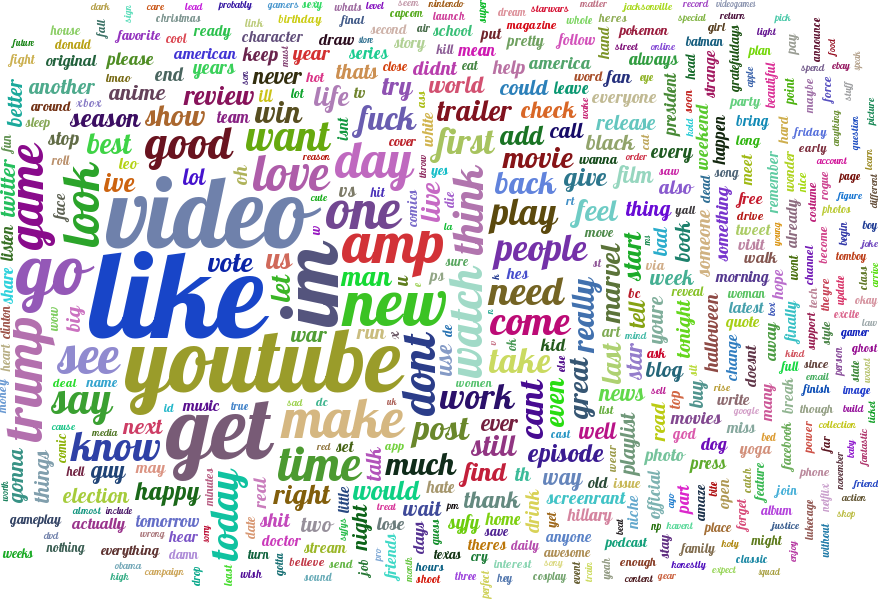

In [118]:
from IPython.display import Image

Image('cloud_large.png')